In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [38]:
def calculate_uncertainty_Entropy(X, model):
    # Get predicted probabilities for each class
    predicted_probs = model.predict_proba(X)    
    # Check for zero probabilities and replace them with a small value
    predicted_probs[predicted_probs == 0] = 1e-10
    # Calculate uncertainty scores using the entropy
    entropy = -np.sum(predicted_probs * np.log2(predicted_probs), axis=1)
    # Handle the case of uniform probabilities
    entropy[np.isnan(entropy)] = 0    
    return entropy

def calculate_uncertainty_Evidence(X_pool, model, TypeOfSelection):
    one_array = np.ones(len(X_pool))
    one_array = np.reshape(one_array, (-1,1))
    X_pool = np.append(one_array,X_pool, axis=1)

    # Extract the parameters (coefficients/betas) of the trained model
    betas = np.transpose(model.coef_)
    # would sort the array of uncertainties (ent_unc) in descending order, thus giving the indices of the most 
    # uncertain data points at the beginning of the sorted index array.
    evidence_scores = []
    number_features = np.shape(X_pool)[1]
    top_uncertain_indices=np.array([])
    batch_size=1
    # A loop is initiated over a range of evid_size_data (which is set to 5 * prams['batch_size'] initially but may be adjusted if the pool size is smaller). 
    if TypeOfSelection==1: # All data
       evid_size_data=len(X_pool)  # by Alaa        
    else:
        evid_size_data =  5 * batch_size
        if len(X_pool) <= evid_size_data:
            evid_size_data = len(X_pool)
        ent_unc=calculate_uncertainty_Entropy(X_pool, model)
        sorted_index = np.argsort(-ent_unc, kind='stable')
        top_uncertain_indices  = sorted_index[:5 * batch_size]
    
    # Within the loop, the code calculates evidence scores for each selected data point. For each data point at current_pool_index, 
    # the corresponding instance (current_pool_instance) is extracted from X_pool. The evidence score is computed by multiplying each
    # feature value of the instance (current_pool_instance[i]) with the 
    # corresponding logistic regression coefficient (betasMll[i]). The evidence scores are stored in the list evidence_scores.
    for index in range(evid_size_data): # for each element
        if TypeOfSelection==1:
            current_pool_instance = X_pool[index]           
        else:
            current_pool_index = top_uncertain_indices[index]
            current_pool_instance = X_pool[current_pool_index]            
        
        scores = [current_pool_instance[i]*betas[i] for i in range(number_features)] 
        scores = scores[1:]
        evidence_positive_class = sum([x for x in scores if x >= 0])
        evidence_negative_class = sum([-x for x in scores if x < 0])
        evidence_scores.append(evidence_positive_class*evidence_negative_class)
    return evidence_scores,top_uncertain_indices

def select_uncertain_Evidence(X_evidence, model, y, labeled_indices, unlabeled_indices_Ev, n_samples, TypeOfSelection): 
    X=X_evidence[:,1:]
    X_pool=X[unlabeled_indices_Ev,:] 
    y_pool=y[unlabeled_indices_Ev]   
    batch_size=1
    evidence_scores, top_uncertain_indices=calculate_uncertainty_Evidence(X_pool, model, TypeOfSelection)
    # Plot the dataset
    plt.scatter(X_pool[y_pool==1, 0], X_pool[y_pool==1, 1], marker='o', c='red', label='Unlabeled points (C1)', s=150)
    plt.scatter(X_pool[y_pool==2, 0], X_pool[y_pool==2, 1], marker='o', c='blue', label='Unlabeled points (C2)', s=150)
    plt.scatter(X[labeled_indices[y[labeled_indices]==1],0], X[labeled_indices[y[labeled_indices]==1],1], marker='+' , c='red', label='Labeled points (C1)', s=320)
    plt.scatter(X[labeled_indices[y[labeled_indices]==2],0], X[labeled_indices[y[labeled_indices]==2],1], marker='+' , c='blue', label='Labeled points (C2)', s=320)
     # Add evidence_scores as text labels
    for i, score in zip(unlabeled_indices_Ev, evidence_scores):
        rounded_score = round(score[0], 2)
        plt.text(X[i, 0], X[i, 1] - 0.25, str(rounded_score), ha='center', va='top', fontsize=15)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Evidence-based Uncertainty')
    plt.legend()
    plt.show()
    
    print("Evidence scores: ")
    print(evidence_scores)
    evid_sorted_index = np.argsort(np.array(evidence_scores).reshape(-1,), kind='stable')
    evid_res_size = batch_size
    if len(X_pool) <= evid_res_size:
        evid_res_size = len(X_pool)
    if TypeOfSelection==2: 
        #conflicting_index_pool = top_uncertain_indices[evid_sorted_index[-evid_res_size:]]
        #insufficient_index_pool = top_uncertain_indices[evid_sorted_index[:evid_res_size]]
        top_uncertain_indices2=unlabeled_indices_Ev[top_uncertain_indices]
        conflicting_index_pool = top_uncertain_indices2[evid_sorted_index[-evid_res_size:]]
        insufficient_index_pool = top_uncertain_indices2[evid_sorted_index[:evid_res_size]]
    else:
        conflicting_index_pool = evid_sorted_index[-n_samples:]
        insufficient_index_pool = evid_sorted_index[0:n_samples]
        
    return conflicting_index_pool, insufficient_index_pool

In [39]:
X=np.array([[1,1], 
           [3,2],
           [4,3],
           [1,3],
           [5,3],
           [3,3],
           [5,4],
           [6,5]])
y=np.array([1,1,1,1,2,2,2,2])
# Set random seed for reproducibility
np.random.seed(42)

one_array = np.ones(len(X))
one_array = np.reshape(one_array, (-1,1))
X_evidence = np.append(one_array,X, axis=1)

In [40]:
model_Evidence = LogisticRegression(fit_intercept=False, solver='liblinear')
labeled_indices = np.array([0,3,4])
unlabeled_indices = np.setdiff1d(np.arange(X.shape[0]), labeled_indices)

In [41]:
n_iterations = 1
n_samples_per_iteration = 2
batch_size=1

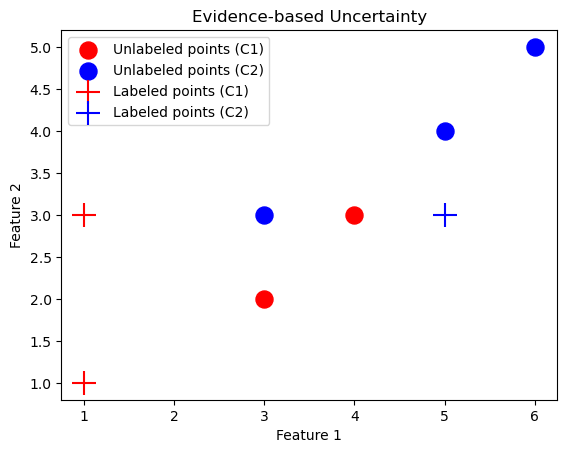

In [42]:
# Plot the dataset
plt.scatter(X[unlabeled_indices[y[unlabeled_indices]==1], 0], X[unlabeled_indices[y[unlabeled_indices]==1], 1], marker='o', c='red', label='Unlabeled points (C1)', s=150)
plt.scatter(X[unlabeled_indices[y[unlabeled_indices]==2], 0], X[unlabeled_indices[y[unlabeled_indices]==2], 1], marker='o', c='blue', label='Unlabeled points (C2)', s=150)
#plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], marker='+' , c='red', label='Labeled points', s=180)
plt.scatter(X[labeled_indices[y[labeled_indices]==1],0], X[labeled_indices[y[labeled_indices]==1],1], marker='+' , c='red', label='Labeled points (C1)', s=320)
plt.scatter(X[labeled_indices[y[labeled_indices]==2],0], X[labeled_indices[y[labeled_indices]==2],1], marker='+' , c='blue', label='Labeled points (C2)', s=320)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Evidence-based Uncertainty')
plt.legend()
plt.show()

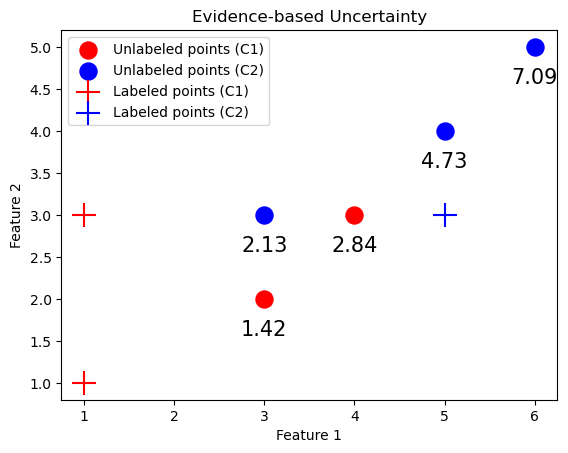

[array([1.41834748]), array([2.83669496]), array([2.12752122]), array([4.72782494]), array([7.09173741])]


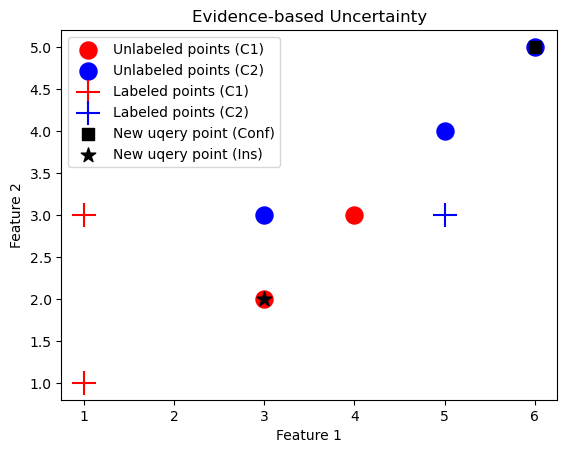

In [43]:
for iteration in range(n_iterations):
    # Train the model on the labeled data
    model_Evidence.fit(X_evidence[labeled_indices], y[labeled_indices])

    # Select uncertain samples from the unlabeled data
    uncertain_indices_Ev_conf,uncertain_indices_Ev_ins = select_uncertain_Evidence(X_evidence, model_Evidence,y,labeled_indices, unlabeled_indices , int(n_samples_per_iteration/2),1)
 
    # Query labels for the uncertain samples
    queried_indices_Ev_conf = unlabeled_indices[uncertain_indices_Ev_conf]
    queried_indices_Ev_ins = unlabeled_indices[uncertain_indices_Ev_ins]
       
    # Plot the dataset
    plt.scatter(X[unlabeled_indices[y[unlabeled_indices]==1], 0], X[unlabeled_indices[y[unlabeled_indices]==1], 1], marker='o', c='red', label='Unlabeled points (C1)', s=150)
    plt.scatter(X[unlabeled_indices[y[unlabeled_indices]==2], 0], X[unlabeled_indices[y[unlabeled_indices]==2], 1], marker='o', c='blue', label='Unlabeled points (C2)', s=150)
    plt.scatter(X[labeled_indices[y[labeled_indices]==1],0], X[labeled_indices[y[labeled_indices]==1],1], marker='+' , c='red', label='Labeled points (C1)', s=320)
    plt.scatter(X[labeled_indices[y[labeled_indices]==2],0], X[labeled_indices[y[labeled_indices]==2],1], marker='+' , c='blue', label='Labeled points (C2)', s=320)
    if y[queried_indices_Ev_conf]==1:
        plt.scatter(X[queried_indices_Ev_conf,0], X[queried_indices_Ev_conf,1], marker='s' , c='black', label='New uqery point (Conf)', s=80)        
    else:
        plt.scatter(X[queried_indices_Ev_conf,0], X[queried_indices_Ev_conf,1], marker='s' , c='black', label='New uqery point (Conf)', s=80)        
    if y[queried_indices_Ev_ins]==1:
        plt.scatter(X[queried_indices_Ev_ins,0], X[queried_indices_Ev_ins,1], marker='*' , c='black', label='New uqery point (Ins)', s=120)        
    else:
        plt.scatter(X[queried_indices_Ev_ins,0], X[queried_indices_Ev_ins,1], marker='*' , c='black', label='New uqery point (Ins)', s=120)        
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Evidence-based Uncertainty')
    plt.legend()
    plt.show()

    queried_labels_Ev = np.r_[y[queried_indices_Ev_conf],y[queried_indices_Ev_ins]]
  
    # Add the queried samples to the labeled set
    labeled_indices = np.concatenate((labeled_indices, queried_indices_Ev_conf, queried_indices_Ev_ins))
  
    # Remove the queried samples from the unlabeled set
    unlabeled_indices = np.setdiff1d(unlabeled_indices, np.r_[queried_indices_Ev_conf,queried_indices_Ev_ins])
